<a href="https://colab.research.google.com/github/td02/Data-Analytics/blob/main/Fetch_TrangDoan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: SQL

In [ ]:
#Unzip json.qz files and create dataframe for each table

import gzip
import json
import shutil
receipts = pd.read_json('/content/receipts.json.gz', lines=True)
brands = pd.read_json('/content/brands.json.gz', lines=True)

with gzip.open('/content/users.json.gz', 'rb') as file_in:
          with open('/content/users.json.gz'.replace('.gz',''), 'wb') as file_out:
            shutil.copyfileobj(file_in, file_out)

users = pd.read_json('users.json', lines=True)


#For MySQL: 
#Which brand has the most spend among users who were created within the past 6 months
Creating a table that joins brands, receipts, and users
<br>WITH summary as 
<br>(select 
  <br>b._id,b.name as brandName,sum(r.totalSpent) as totalSpent,u._id,u. createdDate
<br>from brands as b
<br>inner join receipts as r
<br>on b._id = r.brand_id
<br>inner join users as u
<br>on u._id=r.userId
)
<br>Using the summary table to pull out customers that created their account within 6 months and how much they spent per brand
<br>select brandName, 
<br>sum(totalSpent) over (partition by brandName) as Spent
<br>from summary
<br>where datediff(month, u.createdDate, getdate()) <= 6
<br> order by Spent desc
<br>limit 5;

#Part 3. Data Quality Check


In [ ]:
#Import necessary packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
receipts['rewardsReceiptItemList']

0       [{'barcode': '4011', 'description': 'ITEM NOT ...
1       [{'barcode': '4011', 'description': 'ITEM NOT ...
2       [{'needsFetchReview': False, 'partnerItemId': ...
3       [{'barcode': '4011', 'description': 'ITEM NOT ...
4       [{'barcode': '4011', 'description': 'ITEM NOT ...
                              ...                        
1114    [{'barcode': 'B076FJ92M4', 'description': 'mue...
1115                                                  NaN
1116                                                  NaN
1117    [{'barcode': 'B076FJ92M4', 'description': 'mue...
1118                                                  NaN
Name: rewardsReceiptItemList, Length: 1119, dtype: object

In [ ]:
#Take a quick look of how data look
receipts.info()
receipts.head()

brands.info()
brands.head()

users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      1119 non-null   object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               1119 non-null   object 
 4   dateScanned              1119 non-null   object 
 5   finishedDate             568 non-null    object 
 6   modifyDate               1119 non-null   object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    float64
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptItemList   679 non-null    object 
 12  rewardsReceiptStatus     1119 non-null   object 
 13  totalSpent               684 non-null    float64
 14  userId                  

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
1,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
2,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
3,{'$oid': '5ff1e1eacfcf6c399c274ae6'},True,{'$date': 1609687530554},{'$date': 1609687530597},consumer,Email,WI
4,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI


In [ ]:
#How many missing data?
r_null=receipts.isnull().sum()
b_null=brands.isnull().sum()
u_null=users.isnull().sum()
#How does these missing data look in %?
r_mean = receipts.isnull().mean()
b_mean=brands.isnull().mean()
u_mean=users.isnull().mean()

print(r_mean)

_id                        0.000000
bonusPointsEarned          0.513852
bonusPointsEarnedReason    0.513852
createDate                 0.000000
dateScanned                0.000000
finishedDate               0.492404
modifyDate                 0.000000
pointsAwardedDate          0.520107
pointsEarned               0.455764
purchaseDate               0.400357
purchasedItemCount         0.432529
rewardsReceiptItemList     0.393208
rewardsReceiptStatus       0.000000
totalSpent                 0.388740
userId                     0.000000
dtype: float64


There are some major concern with data when many variables in receipts have more than 40% of data is missing like purchasedItemCount or finishedDate. Or the variable we needed the most when answering what was the most spent brand is totalSpent which has almost 40% missing data.

In [ ]:
#Looking at columns for receipts
list(receipts.columns)
# look at unique userId in receipts
sorted(receipts['userId'].unique(),reverse=False)

['542ace60e4b0b3d724922499',
 '54943462e4b07e684157a532',
 '54ca99a9e4b0b11b4f7d6dc5',
 '5964eb07e4b03efd0c0f267b',
 '59c124bae4b0299e55b0f330',
 '5a43c08fe4b014fd6b6a0612',
 '5c3388caea88e15513a95069',
 '5cd06f1f2acf0a2667da628b',
 '5e27526d0bdb6a138c32b556',
 '5e56d38507a0df22a15dfc85',
 '5f9c74e3f1937815bd2c1d73',
 '5f9c74f7c88c1415cbddb839',
 '5fa32b4d898c7a11a6bcebce',
 '5fa41775898c7a11a6bcef3e',
 '5fa5ad376a26f611e71ab5ef',
 '5fa5b0b720dc5111dd86dcc1',
 '5fa8d542b055fd1dfdf09517',
 '5fa8d573770b516dda4f4d21',
 '5fb0a078be5fc9775c1f3945',
 '5fb1bd519c09d811e5211cef',
 '5fb2da582357ec11d4ecc403',
 '5fbc35711d967d1222cbfefc',
 '5fc961c3b8cfca11a077dd33',
 '5ff1e194b6a9d73a3a9f1052',
 '5ff1e196cfcf6c399c274a38',
 '5ff1e1b4cfcf6c399c274a54',
 '5ff1e1dfcfcf6c399c274ab3',
 '5ff1e1e4cfcf6c399c274ac3',
 '5ff1e1e9b6a9d73a3a9f10f6',
 '5ff1e1eacfcf6c399c274ae6',
 '5ff1e1f1cfcf6c399c274b0b',
 '5ff36a3862fde912123a4460',
 '5ff36be7135e7011bcb856d3',
 '5ff36d0362fde912123a5535',
 '5ff36d78135e

In [ ]:
#find unique values in users but the list contains unhashable elements so we can use repr with a set to find unique values:
def unique_list(a_list):
    seen = set()
    for x in a_list:
        key = repr(x)
        if key not in seen:
            seen.add(key)
            print(x)

unique_list(users['_id'])

{'$oid': '5ff1e194b6a9d73a3a9f1052'}
{'$oid': '5ff1e1eacfcf6c399c274ae6'}
{'$oid': '5ff1e1e8cfcf6c399c274ad9'}
{'$oid': '5ff1e1b7cfcf6c399c274a5a'}
{'$oid': '5ff1e1f1cfcf6c399c274b0b'}
{'$oid': '5ff1e1e4cfcf6c399c274ac3'}
{'$oid': '5ff1e1b4cfcf6c399c274a54'}
{'$oid': '5ff370c562fde912123a5e0e'}
{'$oid': '5ff36d0362fde912123a5535'}
{'$oid': '5ff36d83135e7011bcb864d6'}
{'$oid': '5ff36c8862fde912123a538a'}
{'$oid': '5ff36be7135e7011bcb856d3'}
{'$oid': '5ff36a3862fde912123a4460'}
{'$oid': '5ff36c8e135e7011bcb85da4'}
{'$oid': '5ff3711e62fde912123a620e'}
{'$oid': '5ff4ce33c3d63511e2a484b6'}
{'$oid': '5ff473e7c1e2d0121a9b2697'}
{'$oid': '5ff47392c3d63511e2a47881'}
{'$oid': '5ff4ce91c1e2d0121a9b3057'}
{'$oid': '5ff4ce3dc3d63511e2a484dc'}
{'$oid': '5ff4ce34c3d63511e2a484ba'}
{'$oid': '5ff4ce3ac1e2d0121a9b2fb3'}
{'$oid': '5ff5d15aeb7c7d12096d91a2'}
{'$oid': '5ff5d1a38f142f11dd1886ba'}
{'$oid': '5ff5d1d08f142f11dd18884c'}
{'$oid': '5ff7264e8f142f11dd189504'}
{'$oid': '5ff7401ceb7c7d31ca8a46e0'}
{

In [ ]:
# out of these totalSpent missing entries, check if they have any values that have 0?
totalS=receipts['totalSpent']
sum(totalS==0)
# So these missing data means invalid and not because their order value is 0

15

In [ ]:
#Finding duplicates in brands
brands['name'].unique()

array(['test brand @1612366101024', 'Starbucks',
       'test brand @1612366146176', ..., 'test brand @1598639215217',
       'LIPTON TEA Leaves', 'test brand @1613158231643'], dtype=object)

I wanted to see how many unique records are there in my variable of interest and how does it correlate with brand name. This will help to see if I need to do a group by with brand id or brand name. Brand name might not be consistent due to spelling errors or spacing. 

I noticed there are a lot of test brand in this dataset - something we need to exclude before performing any SQL queries. 

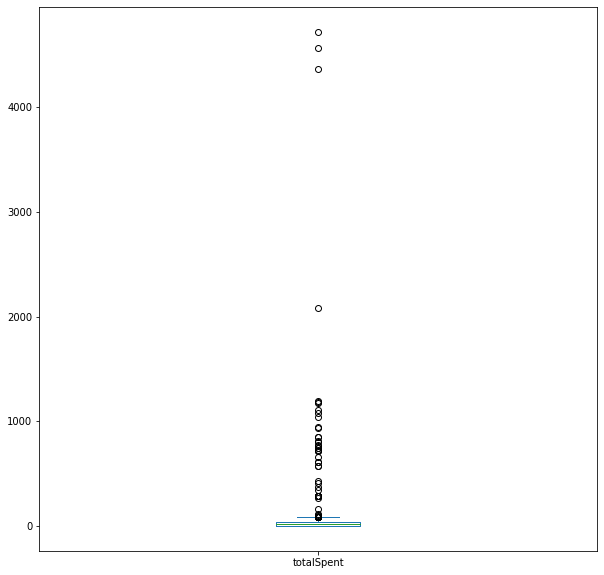

In [ ]:
# Plotting outliers using boxplot 
df = receipts['totalSpent']
df.plot(kind='box', figsize =(10,10))

We notice some outliners for totalSpent - we need take a closer look at these outliners to see whether it is a data entry error or something else. 

Text(0.5, 1.0, 'Correlation Heatmap')

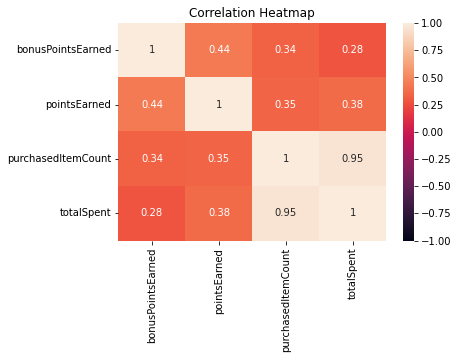

In [ ]:
#Further Exploration
corr = receipts.corr()
heatmap=sns.heatmap (corr, vmin=-1,vmax=1, annot =True)
heatmap.set_title('Correlation Heatmap')


In this scenario we will explore correlation between variables in receipts. No signficant correlation was found

#Part 4: Email

Hi Team, 

I noticed a few items that need to addressed regarding to Data Quality with Receipts, Brands, and Users dataset. 

1. Some of _id in Brands were called test_brands - how would you like us to go about this when coming to business decision?  
2. Lots of missing data in totalSpent- how does the data was recorded? Was it recorded as the user scanned their receipt or when the receipt finishes processing?
3. topBrand should be Boolean indicator to avoid null values
4. What was the data format? Make sure they have to be consistent throughout the database. 
5. Nested JSON in rewardsReceiptsItemList column should be expanded which could help improving efficiency and analysis. 

I also wanted to know how the data was recorded. Will they get updated in real time?

Let me know when you are available to talk over these issues. 

Best regards, 

